In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Algorithm (Example: Random Forest Classifier, good for this type of task)
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb # XGBoost is also a strong candidate

# --- Configuration ---
MODEL_NAME_PREFIX = "weather_impact" # Changed from "weather" to be more descriptive
TARGET_COLUMN = "WeatherImpactLevel" # Our NEW derived categorical target
DATA_PATH = '../data/TAS_Airport_Data_2024_cleaned_exploratory.csv'
MODELS_DIR = '../models/'
MODELS_META_DIR = '../models_meta/'

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(MODELS_META_DIR, exist_ok=True)


# CRISP-DM Phase: Data Understanding & Preparation

In [2]:
# 1. Load Data
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.columns = df.columns.str.strip()

# 2. Derive Target Variable: WeatherImpactLevel
print("\n--- Deriving Target Variable: WeatherImpactLevel ---")
# This is a SIMPLIFIED example. You need to define robust rules.
# We'll use 'WeatherCondition' and 'ArrivalDelay' as an example.
# Ensure 'ArrivalDelay' is numeric and 'WeatherCondition' exists
if 'ArrivalDelay' not in df.columns or 'WeatherCondition' not in df.columns:
    raise ValueError("Required columns 'ArrivalDelay' and/or 'WeatherCondition' not found for target derivation.")

df['ArrivalDelay'] = pd.to_numeric(df['ArrivalDelay'], errors='coerce')
df.dropna(subset=['ArrivalDelay', 'WeatherCondition'], inplace=True) # Need these for target

conditions_high_impact = ["Heavy Rain", "Snow", "Fog", "Thunderstorm", "Freezing Rain"] # Add more as needed
conditions_moderate_impact = ["Rain", "Light Snow", "Sleet", "Drizzle"] # Add more

def derive_impact_level(row):
    delay = row['ArrivalDelay']
    condition = str(row['WeatherCondition']).strip() # Ensure it's a string and stripped

    if condition in conditions_high_impact:
        if delay > 60: return "High"
        elif delay > 30: return "Moderate"
        else: return "Low" # High-risk condition but low observed delay
    elif condition in conditions_moderate_impact:
        if delay > 45: return "High" # Moderate condition causing high delay
        elif delay > 20: return "Moderate"
        else: return "Low"
    else: # "Clear", "Cloudy", "Partly Cloudy", "Windy", "Unknown" etc.
        if delay > 60: return "Moderate" # Clear weather but high delay (likely not weather related, but model might learn this)
        else: return "Low"

df[TARGET_COLUMN] = df.apply(derive_impact_level, axis=1)

print(f"Derived '{TARGET_COLUMN}' value counts:")
print(df[TARGET_COLUMN].value_counts())
num_target_classes_weather = df[TARGET_COLUMN].nunique()

# Label Encode the Target Variable
le_weather = LabelEncoder()
y_encoded_weather = le_weather.fit_transform(df[TARGET_COLUMN])

label_encoder_filename_weather = f"label_encoder_{MODEL_NAME_PREFIX}.pkl"
label_encoder_path_weather = os.path.join(MODELS_META_DIR, label_encoder_filename_weather)
joblib.dump(le_weather, label_encoder_path_weather)
print(f"Label encoder for {TARGET_COLUMN} saved to: {label_encoder_path_weather}")
print(f"Target classes: {list(le_weather.classes_)}")

y = pd.Series(y_encoded_weather, index=df.index)

# Define Initial Features (X_initial)
# We predict impact based on observable conditions BEFORE the flight outcome is fully known.
# So, we should not use 'ArrivalDelay' or 'DepartureDelay' as direct features if target is derived from them.
# 'FlightID', 'ReasonForDelay', 'OnTimePerformance', 'Gate' are outcomes.
X_initial = df.drop(columns=[
    TARGET_COLUMN, 'ArrivalDelay', 'DepartureDelay', # Used to derive target, so drop
    'FlightID', 'ReasonForDelay', 'OnTimePerformance', 'Gate'
])


# 3. Feature Engineering
print("\n--- Feature Engineering ---")

# Datetime features (e.g., from ScheduledArrivalTime or ScheduledTime - time of day/season matters for weather)
# For this example, let's use ScheduledArrivalTime as the reference time for weather conditions
if 'ScheduledArrivalTime' in X_initial.columns:
    X_initial['ScheduledArrivalTime'] = pd.to_datetime(X_initial['ScheduledArrivalTime'], errors='coerce')
    X_initial['WeatherObs_Hour'] = X_initial['ScheduledArrivalTime'].dt.hour
    X_initial['WeatherObs_Month'] = X_initial['ScheduledArrivalTime'].dt.month
    X_initial['WeatherObs_DayOfWeek'] = X_initial['ScheduledArrivalTime'].dt.dayofweek
    X_initial = X_initial.drop(columns=['ScheduledArrivalTime'])
    print("Engineered datetime features based on ScheduledArrivalTime.")
elif 'ScheduledTime' in X_initial.columns: # Fallback to ScheduledTime (departure)
    X_initial['ScheduledTime'] = pd.to_datetime(X_initial['ScheduledTime'], errors='coerce')
    X_initial['WeatherObs_Hour'] = X_initial['ScheduledTime'].dt.hour
    X_initial['WeatherObs_Month'] = X_initial['ScheduledTime'].dt.month
    X_initial['WeatherObs_DayOfWeek'] = X_initial['ScheduledTime'].dt.dayofweek
    X_initial = X_initial.drop(columns=['ScheduledTime'])
    print("Engineered datetime features based on ScheduledTime (as fallback).")
else:
    print("Warning: No suitable datetime column found for weather observation time context.")


# Other potentially relevant features:
# 'Airline', 'OriginAirport', 'ArrivalAirport', 'AircraftType' (some aircraft handle weather better)
# 'FlightDuration' (longer flights have more exposure)
# Resource columns like 'BaggageHandlers', 'GroundCrew' might be adjusted based on weather forecasts,
# making them inputs rather than outcomes for this specific model.

# Align X and y
X_initial = X_initial.loc[y.index]
print(f"Shape of X_initial after feature engineering: {X_initial.shape}")
print(f"Shape of y after aligning: {y.shape}")

# 4. Identify Feature Types for Preprocessing
numerical_features = X_initial.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_initial.select_dtypes(include=['object', 'category']).columns.tolist()

# 'WeatherCondition' is a key categorical feature here.
if 'WeatherCondition' not in categorical_features and 'WeatherCondition' in X_initial.columns:
    categorical_features.append('WeatherCondition')
    if 'WeatherCondition' in numerical_features: numerical_features.remove('WeatherCondition')


print(f"\nIdentified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")

# 5. Split Data into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.25, random_state=42, stratify=y)
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# 6. Create Preprocessing Pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

active_numerical_features = [col for col in numerical_features if col in X_train.columns]
active_categorical_features = [col for col in categorical_features if col in X_train.columns]

preprocessor_weather = ColumnTransformer([
    ('num', numerical_pipeline, active_numerical_features),
    ('cat', categorical_pipeline, active_categorical_features)
], remainder='drop')





--- Deriving Target Variable: WeatherImpactLevel ---
Derived 'WeatherImpactLevel' value counts:
WeatherImpactLevel
Low         32761
Moderate      179
Name: count, dtype: int64
Label encoder for WeatherImpactLevel saved to: ../models_meta/label_encoder_weather_impact.pkl
Target classes: ['Low', 'Moderate']

--- Feature Engineering ---
Engineered datetime features based on ScheduledArrivalTime.
Shape of X_initial after feature engineering: (32940, 28)
Shape of y after aligning: (32940,)

Identified Numerical Features: ['FlightDuration', 'BaggageHandlers', 'GroundCrew', 'FuelTrucks', 'CleaningCrew', 'Passengers', 'SecurityChecks', 'RunwayDelay', 'PreviousFlightDelay', 'AircraftTurnaroundTime', 'CheckInQueueTime', 'SecurityWaitTime', 'BaggageClaimBelts', 'CustomsOfficers', 'ImmigrationOfficers', 'WeatherObs_Hour', 'WeatherObs_Month', 'WeatherObs_DayOfWeek']
Identified Categorical Features: ['Airline', 'DepartureAirport', 'ArrivalAirport', 'OriginAirport', 'ScheduledTime', 'AircraftType',

# CRISP-DM Phase: Modeling 

In [3]:


# 7. Fit the Preprocessor on the Training Data
print("\n--- Fitting Preprocessor ---")
X_train_processed_np = preprocessor_weather.fit_transform(X_train)
feature_names_processed_weather = list(preprocessor_weather.get_feature_names_out())
X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_processed_weather, index=X_train.index)
print(f"Shape of X_train_processed: {X_train_processed.shape}")

# Transform the Test Data
X_test_processed_np = preprocessor_weather.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_processed_weather, index=X_test.index)
print(f"Shape of X_test_processed: {X_test_processed.shape}")

# 8. Define and Train the Model (Random Forest Classifier)
print("\n--- Model Training ---")
rf_clf_weather = RandomForestClassifier(
    n_estimators=100,     # Number of trees
    max_depth=10,         # Max depth of trees
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' # Good for imbalanced classes if any
)

# Or XGBoost:
# objective_weather = 'binary:logistic' if num_target_classes_weather == 2 else 'multi:softmax'
# xgb_clf_weather = xgb.XGBClassifier(
#     objective=objective_weather,
#     num_class=num_target_classes_weather if num_target_classes_weather > 2 else None,
#     n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, use_label_encoder=False
# )
# model_to_train = xgb_clf_weather

model_to_train = rf_clf_weather # Using RandomForest for this example

# Optional: Hyperparameter Tuning
# param_grid_rf = {'n_estimators': [100, 150], 'max_depth': [10, 15, None], 'min_samples_leaf': [1, 2, 4]}
# grid_search_rf = GridSearchCV(estimator=rf_clf_weather, param_grid=param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search_rf.fit(X_train_processed, y_train)
# model_to_train = grid_search_rf.best_estimator_

model_to_train.fit(X_train_processed, y_train) # y_train is label encoded
print("Model training complete.")






--- Fitting Preprocessor ---
Shape of X_train_processed: (24705, 12154)
Shape of X_test_processed: (8235, 12154)

--- Model Training ---
Model training complete.


# CRISP-DM Phase: Evaluation


--- Model Evaluation ---

--- Training Set Metrics (Weather Impact Level) ---
Accuracy: 0.5076
Classification Report (Training):
              precision    recall  f1-score   support

         Low       1.00      0.50      0.67     24571
    Moderate       0.01      1.00      0.02       134

    accuracy                           0.51     24705
   macro avg       0.51      0.75      0.35     24705
weighted avg       0.99      0.51      0.67     24705


--- Test Set Metrics (Weather Impact Level) ---
Accuracy: 0.4990
Classification Report (Test):
              precision    recall  f1-score   support

         Low       1.00      0.50      0.66      8190
    Moderate       0.01      1.00      0.02        45

    accuracy                           0.50      8235
   macro avg       0.51      0.75      0.34      8235
weighted avg       0.99      0.50      0.66      8235



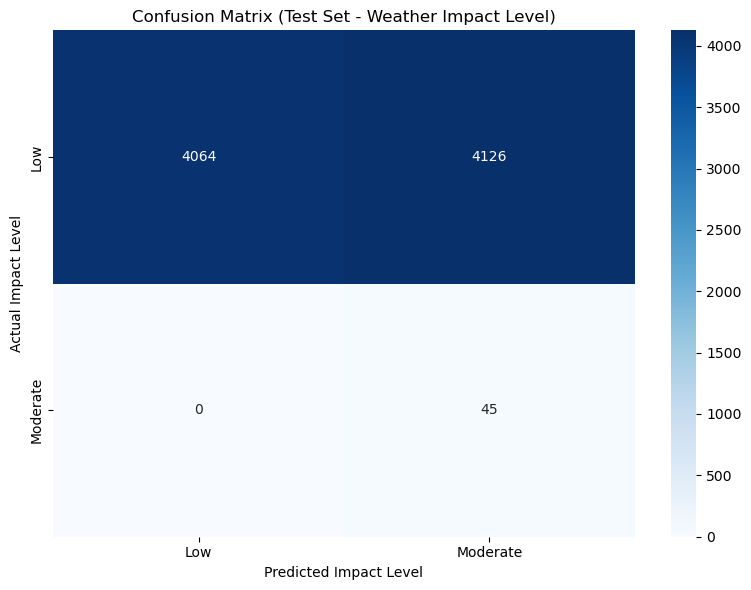

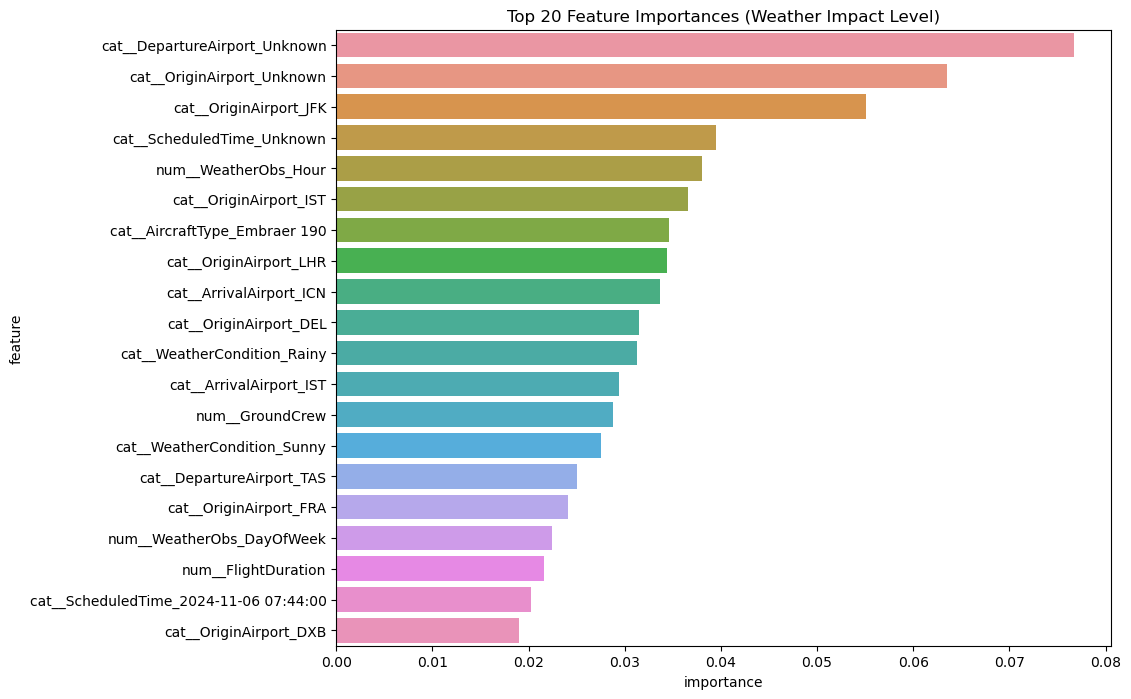

In [4]:

print("\n--- Model Evaluation ---")
y_pred_train_encoded_weather = model_to_train.predict(X_train_processed)
y_pred_test_encoded_weather = model_to_train.predict(X_test_processed)

y_pred_train_labels_weather = le_weather.inverse_transform(y_pred_train_encoded_weather)
y_pred_test_labels_weather = le_weather.inverse_transform(y_pred_test_encoded_weather)
y_train_labels_weather = le_weather.inverse_transform(y_train)
y_test_labels_weather = le_weather.inverse_transform(y_test)

print("\n--- Training Set Metrics (Weather Impact Level) ---")
print(f"Accuracy: {accuracy_score(y_train_labels_weather, y_pred_train_labels_weather):.4f}")
print("Classification Report (Training):")
print(classification_report(y_train_labels_weather, y_pred_train_labels_weather, zero_division=0))

print("\n--- Test Set Metrics (Weather Impact Level) ---")
print(f"Accuracy: {accuracy_score(y_test_labels_weather, y_pred_test_labels_weather):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test_labels_weather, y_pred_test_labels_weather, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8,6))
cm_weather = confusion_matrix(y_test_labels_weather, y_pred_test_labels_weather, labels=le_weather.classes_)
sns.heatmap(cm_weather, annot=True, fmt='d', cmap='Blues', xticklabels=le_weather.classes_, yticklabels=le_weather.classes_)
plt.title('Confusion Matrix (Test Set - Weather Impact Level)')
plt.xlabel('Predicted Impact Level')
plt.ylabel('Actual Impact Level')
plt.tight_layout()
plt.show()

# Feature Importance
if hasattr(model_to_train, 'feature_importances_'):
    importances_weather = model_to_train.feature_importances_
    feature_importance_df_weather = pd.DataFrame({'feature': feature_names_processed_weather, 'importance': importances_weather})
    feature_importance_df_weather = feature_importance_df_weather.sort_values(by='importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_weather)
    plt.title('Top 20 Feature Importances (Weather Impact Level)')
    plt.show()





# CRISP-DM Phase: Deployment (Saving Artifacts) 

In [5]:

print("\n--- Saving Artifacts ---")

# 1. Save the Preprocessor
preprocessor_filename_weather = f"preprocessor_{MODEL_NAME_PREFIX}.pkl"
preprocessor_path_weather = os.path.join(MODELS_META_DIR, preprocessor_filename_weather)
joblib.dump(preprocessor_weather, preprocessor_path_weather)
print(f"Preprocessor saved to: {preprocessor_path_weather}")

# 2. Save the list of Processed Feature Names
feature_names_filename_weather = f"feature_names_{MODEL_NAME_PREFIX}.pkl"
feature_names_path_weather = os.path.join(MODELS_META_DIR, feature_names_filename_weather)
joblib.dump(feature_names_processed_weather, feature_names_path_weather)
print(f"Feature names saved to: {feature_names_path_weather}")

# 3. Save the Trained Model (weather_estimation.pkl)
final_model_name_for_dashboard_weather = "weather_estimation.pkl"
model_path_weather = os.path.join(MODELS_DIR, final_model_name_for_dashboard_weather)
joblib.dump(model_to_train, model_path_weather)
print(f"Trained model saved to: {model_path_weather}")


--- Saving Artifacts ---
Preprocessor saved to: ../models_meta/preprocessor_weather_impact.pkl
Feature names saved to: ../models_meta/feature_names_weather_impact.pkl
Trained model saved to: ../models/weather_estimation.pkl
